In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')


In [4]:
df = pd.read_csv('C:/Users/patha/Downloads/boxoffice.csv', encoding='latin-1')
# Ensure that the line below is at the same indentation level as the previous line
# Add any necessary code here
df.head()

,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,Star Wars: Episode VIII - The Last Jedi,"$620,181,382","$1,332,539,889",Walt Disney Studios Motion Pictures,"$220,009,584","4,232","$317,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi",382
1,The Fate of the Furious,"$226,008,385","$1,236,005,118",Universal Pictures,"$98,786,705","4,310","$250,000,000",PG-13,"Action,Adventure,Thriller",262
2,Wonder Woman,"$412,563,408","$821,847,012",Warner Bros.,"$103,251,471","4,165","$149,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi,War",217
3,Guardians of the Galaxy Vol. 2,"$389,813,101","$863,756,051",Walt Disney Studios Motion Pictures,"$146,510,104","4,347","$200,000,000",PG-13,"Action,Adventure,Comedy,Sci-Fi",241
4,Beauty and the Beast,"$504,014,165","$1,263,521,126",Walt Disney Studios Motion Pictures,"$174,750,616","4,210","$160,000,000",PG,"Family,Fantasy,Musical,Romance",290


In [5]:
df.shape


(2694, 10)

In [6]:
df.shape


(2694, 10)

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   object
 2   world_revenue     2694 non-null   object
 3   distributor       2694 non-null   object
 4   opening_revenue   2390 non-null   object
 5   opening_theaters  2383 non-null   object
 6   budget            397 non-null    object
 7   MPAA              1225 non-null   object
 8   genres            2655 non-null   object
 9   release_days      2694 non-null   object
dtypes: object(10)
memory usage: 210.6+ KB


In [8]:
df.describe().T


,count,unique,top,freq
title,2694,2468,A Beautiful Planet,3
domestic_revenue,2694,2495,"$11,272,008",3
world_revenue,2694,2501,"$25,681,505",3
distributor,2694,248,Fathom Events,292
opening_revenue,2390,2176,"$4,696",3
opening_theaters,2383,732,1,503
budget,397,124,"$40,000,000",14
MPAA,1225,8,R,568
genres,2655,567,Documentary,351
release_days,2694,457,347,35


In [9]:
# We will be predicting only
# domestic_revenue in this article.

to_remove = ['world_revenue', 'opening_revenue']
df.drop(to_remove, axis=1, inplace=True)


In [10]:
df.isnull().sum() * 100 / df.shape[0]


title                0.000000
domestic_revenue     0.000000
distributor          0.000000
opening_theaters    11.544172
budget              85.263549
MPAA                54.528582
genres               1.447661
release_days         0.000000
dtype: float64

In [11]:
# Handling the null value columns
df.drop('budget', axis=1, inplace=True)

for col in ['MPAA', 'genres']:
	df[col] = df[col].fillna(df[col].mode()[0])

df.dropna(inplace=True)

df.isnull().sum().sum()


0

In [12]:
df['domestic_revenue'] = df['domestic_revenue'].str[1:]

for col in ['domestic_revenue', 'opening_theaters', 'release_days']:
	df[col] = df[col].str.replace(',', '')

	# Selecting rows with no null values
	# in the columns on which we are iterating.
	temp = (~df[col].isnull())
	df[temp][col] = df[temp][col].convert_dtypes(float)

	df[col] = pd.to_numeric(df[col], errors='coerce')


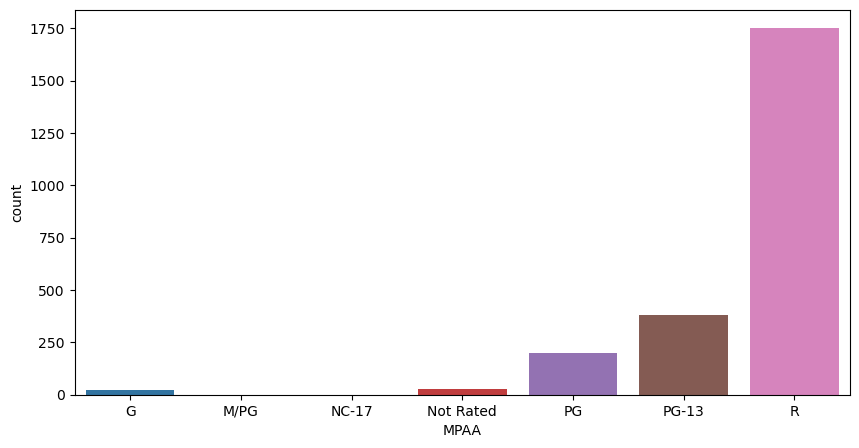

In [14]:
df['MPAA'] = df['MPAA'].astype('category')
plt.figure(figsize=(10, 5))
sb.countplot(data=df, x='MPAA')
plt.show()


In [15]:
df.groupby('MPAA').mean()['domestic_revenue']


MPAA
G            3.539276e+07
M/PG         5.113500e+05
NC-17        1.368800e+04
Not Rated    4.897703e+05
PG           5.379622e+07
PG-13        5.891966e+07
R            6.591336e+06
Name: domestic_revenue, dtype: float64

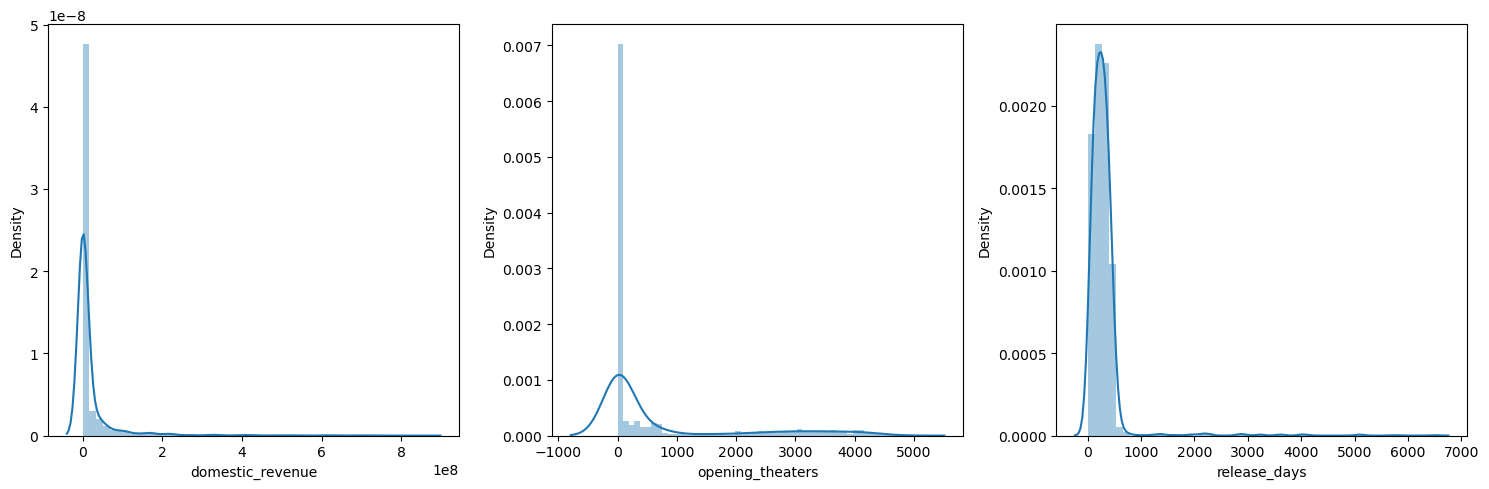

In [16]:
plt.subplots(figsize=(15, 5))

features = ['domestic_revenue', 'opening_theaters', 'release_days']
for i, col in enumerate(features):
	plt.subplot(1, 3, i+1)
	sb.distplot(df[col])
plt.tight_layout()
plt.show()


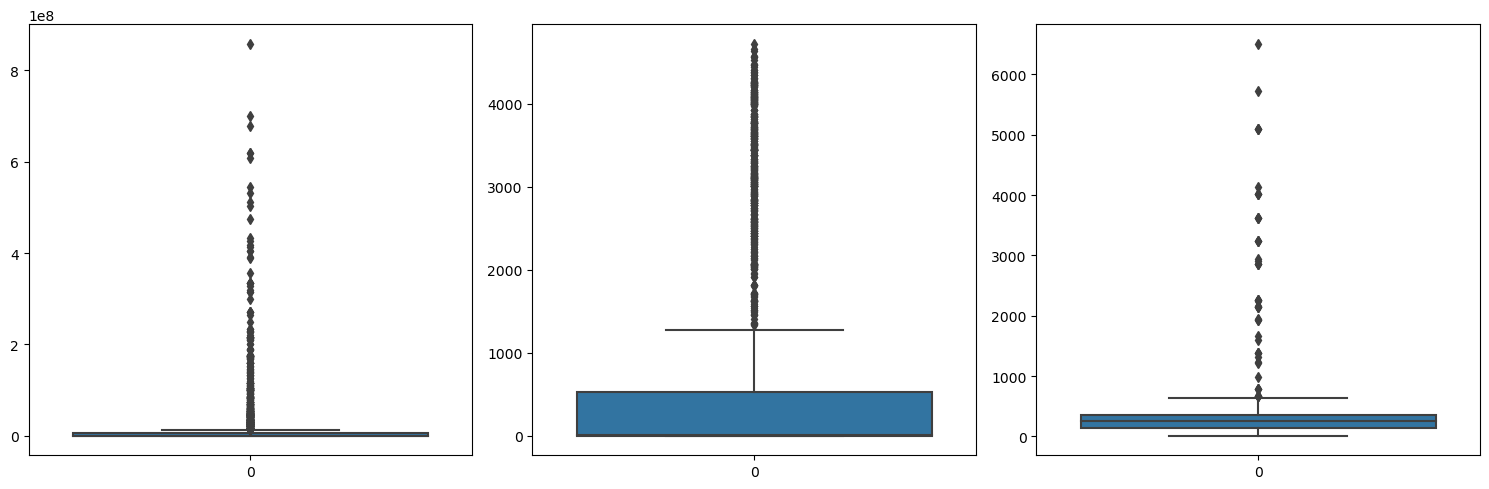

In [17]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
	plt.subplot(1, 3, i+1)
	sb.boxplot(df[col])
plt.tight_layout()
plt.show()


In [21]:
import numpy as np

for col in df.columns:
    try:
        df[col] = df[col].apply(lambda x: np.log10(x) if x > 0 else np.nan)
    except (ValueError, TypeError):
        df[col] = np.nan
    # Add additional code within the loop if necessary


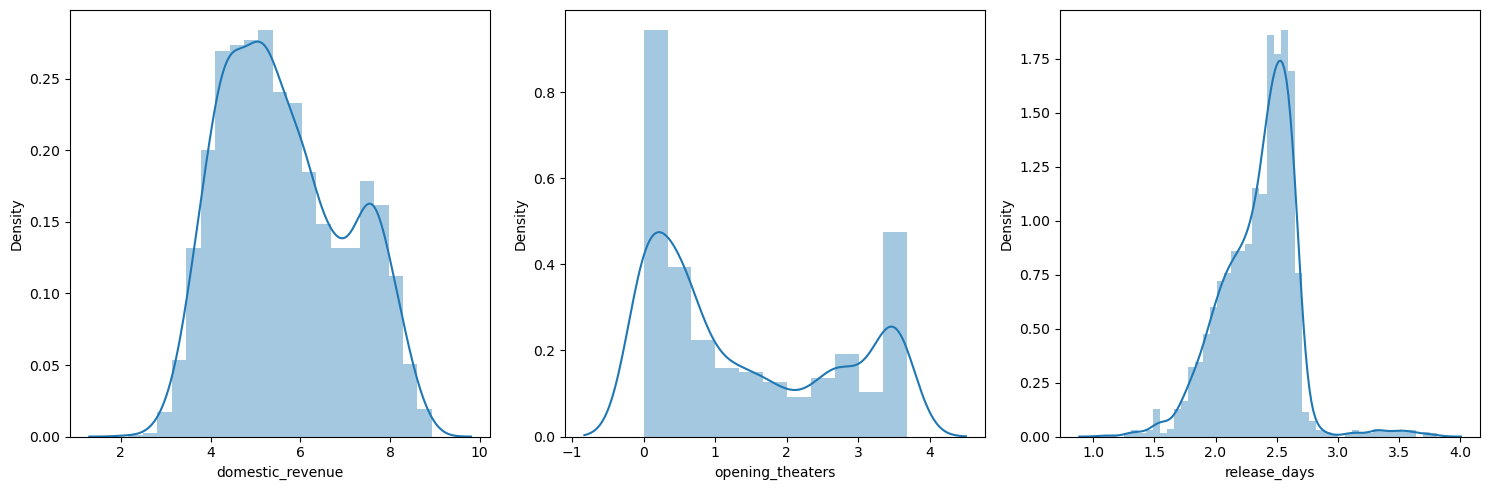

In [22]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
	plt.subplot(1, 3, i+1)
	sb.distplot(df[col])
plt.tight_layout()
plt.show()


In [28]:
removed = 0
selected_columns = ['action', 'western']  # Adjust the list of column names as needed
existing_columns = [col for col in selected_columns if col in df.columns]

for col in existing_columns:
    if (df[col] == 0).mean() > 0.95:
        df.drop(col, axis=1, inplace=True)
        removed += 1


In [29]:
for col in ['distributor', 'MPAA']:
	le = LabelEncoder()
	df[col] = le.fit_transform(df[col])


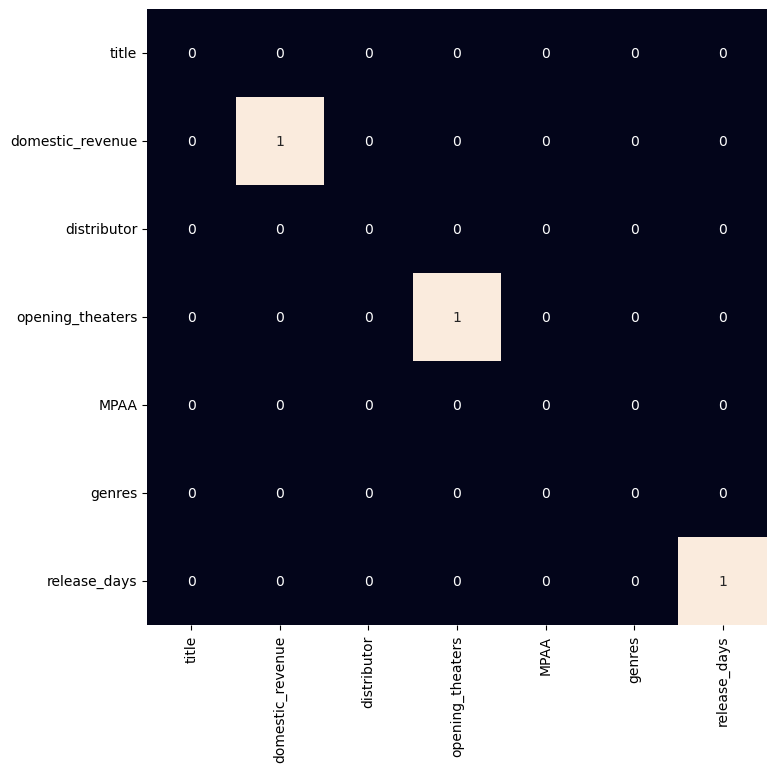

In [30]:
plt.figure(figsize=(8, 8))
sb.heatmap(df.corr() > 0.8,
		annot=True,
		cbar=False)
plt.show()


In [32]:
columns_to_drop = ['title', 'domestic_revenue', 'fi']  # Adjust the list of column names as needed
existing_columns = [col for col in columns_to_drop if col in df.columns]

features = df.drop(existing_columns, axis=1)
target = df['domestic_revenue'].values

X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.1, random_state=22)


In [33]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [34]:
from sklearn.metrics import mean_absolute_error as mae
model = XGBRegressor()
model.fit(X_train, Y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Assuming models is a list of LinearRegression models
models = [XGBRegressor()]

# Train and evaluate the model
i = 0  # Index of the model you want to use

models[i].fit(X_train, Y_train)  # Fit the model with training data

train_preds = models[i].predict(X_train)
print('Training Error:', mean_absolute_error(Y_train, train_preds))

val_preds = models[i].predict(X_val)
print('Validation Error:', mean_absolute_error(Y_val, val_preds))
print()


Training Error: 0.29490252328365263
Validation Error: 0.5268970608560303

